Task 1: Top 5 Products by Sales in 2022 for the "Mobiles & Tablets" Category Scenario: The Marketing Team is preparing for a Year-End Festival and needs to identify the top 5 products in the "Mobiles & Tablets" category that had the highest sales quantities in 2022. The products should be filtered to ensure only valid orders are included. Requirements: • Filter the data to include only products from the "Mobiles & Tablets" category in 2022, where the is_valid feature is set to 1. • Group the data by sku_name and category, and sum the qty_ordered for each product. • Rank the products based on their total sales quantity in descending order. • Display the top 5 products with the highest sales quantities. • Generate a horizontal bar chart showing the top 5 products by quantity. Key Features to Use: • category • order_date (for filtering by year) • is_valid (to filter valid orders) • sku_name (for product names) • qty_ordered (for sales quantities)

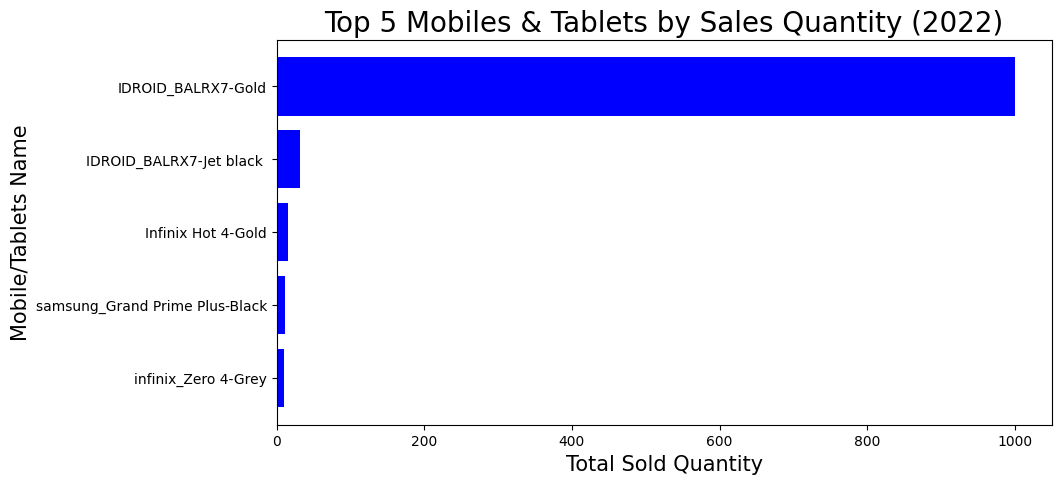

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("orders.csv")

filtered_df = df[
    (df['category'] == 'Mobiles & Tablets') &
    (pd.to_datetime(df['order_date']).dt.year == 2022) &
    (df['is_valid'] == 1)
]

grouped_df = (
    filtered_df.groupby(['sku_name', 'category'])['qty_ordered']
    .sum()
    .reset_index()
    .sort_values(by='qty_ordered', ascending=False)
)

top5_df = grouped_df.head(5)
plt.figure(figsize=(10,5))
plt.barh(top5_df['sku_name'], top5_df['qty_ordered'], color='blue')
plt.xlabel('Total Sold Quantity',size=15)
plt.ylabel('Mobile/Tablets Name',size=15)
plt.title('Top 5 Mobiles & Tablets by Sales Quantity (2022)',size=20)
plt.gca().invert_yaxis()
plt.show()


Task 2: Analyzing Sales Decrease in the "Others" Category Between 2021 and 2022 Scenario: The Warehouse Team has observed a surplus in the stock of "Others" category products at the end of 2022. They would like to know if sales have declined in 2022 compared to 2021. Additionally, they want to see the 20 products that experienced the largest decrease in sales. Requirements: 1. Create two datasets: o One for sales data in 2021 (qty_ordered for "Others" category). o One for sales data in 2022 (qty_ordered for "Others" category). 2. Merge the datasets and calculate the sales difference between 2022 and 2021. 3. Calculate the percentage change in sales and classify it as "DOWN", "UP", or "FAIR". 4. Sort the products by the largest decrease in sales and show the top 20 products. 5. Create a horizontal bar chart to display the products with the largest decrease in sales between 2022 and 2021. Key Features to Use: • category • order_date (for filtering by year) • is_valid • sku_name • qty_ordered

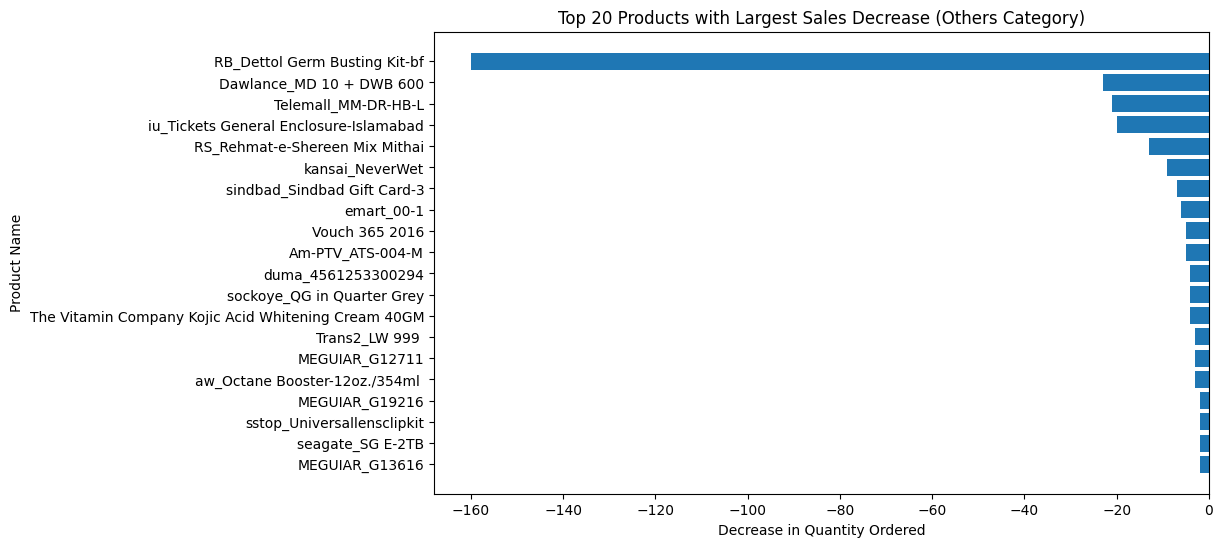

In [43]:
df['order_date'] = pd.to_datetime(df['order_date'])
others_df = df[(df['category'] == 'Others') & (df['is_valid'] == 1)]
sales_2021 = others_df[others_df['order_date'].dt.year == 2021].groupby('sku_name', as_index=False)['qty_ordered'].sum()
sales_2022 = others_df[others_df['order_date'].dt.year == 2022].groupby('sku_name', as_index=False)['qty_ordered'].sum()

sales_2021.rename(columns={'qty_ordered': 'qty_2021'}, inplace=True)
sales_2022.rename(columns={'qty_ordered': 'qty_2022'}, inplace=True)

merged = pd.merge(sales_2021, sales_2022, on='sku_name', how='outer').fillna(0)
merged['difference'] = merged['qty_2022'] - merged['qty_2021']
merged['pct_change'] = ((merged['qty_2022'] - merged['qty_2021']) / merged['qty_2021'].replace(0, 1)) * 100

def classify(change):
    if change < -10:
        return 'DOWN'
    elif change > 10:
        return 'UP'
    else:
        return 'FAIR'

merged['trend'] = merged['pct_change'].apply(classify)

top20_decrease = merged.sort_values(by='difference', ascending=True).head(20)


plt.figure(figsize=(10,6))
plt.barh(top20_decrease['sku_name'], top20_decrease['difference'])
plt.xlabel('Decrease in Quantity Ordered')
plt.ylabel('Product Name')
plt.title('Top 20 Products with Largest Sales Decrease (Others Category)')
plt.gca().invert_yaxis()
plt.show()



Task 3: Identifying Customers Who Completed Checkout but Didn't Pay in 2022 Scenario: The Digital Marketing Team wants to identify customers who completed the checkout process but did not make a payment in 2022. This will help them reach out for promotional purposes. Requirements: • Filter the data to find records where is_gross is 1 (indicating completed che• Retrieve the customer_id and registered_date for these records. • Ensure there are no duplicate customer_id entries. • Share the compiled data with the Marketing Team. Key Features to Use: • is_gross (for checkout status) • is_valid, is_net (to filter invalid or net transactions) • order_date (for filtering by year) • customer_id • registered_dateckout but no payment), is_valid is 0, and is_net is 0, for the year 2022.

In [44]:
df['is_gross'] = 1
df['is_net'] = 0
df['customer_id'] = range(1, len(df) + 1)
df['registered_date'] = df['order_date']

filtered_df = df[
    (df['is_gross'] == 1) &   
    (df['is_valid'] == 0) &  
    (df['is_net'] == 0) &      
    (df['order_date'].dt.year == 2022)
]

result_df = filtered_df[['customer_id', 'registered_date']].drop_duplicates()
display(result_df)
result_df['customer_id'].nunique()
result_df.to_csv("Task_Customers_NotPaid_2022.csv", index=False)



,customer_id,registered_date
0,1,2022-02-23
8,9,2022-07-26
19,20,2022-10-07
22,23,2022-04-16
23,24,2022-02-06
...,...,...
5729,5730,2022-06-08
5734,5735,2022-06-19
5742,5743,2022-06-18
5756,5757,2022-06-25


Task 4:Comparing Weekend and Weekday Sales in Q4 2022 Scenario: The Campaign Team wants to evaluate the effectiveness of their weekend promotional campaigns (Saturdays and Sundays) between October and December 2022 by comparing the average daily sales during weekends vs weekdays. Requirements: 1. Calculate the average daily sales (before_discount) for weekends (Saturdays and Sundays) and weekdays (Monday to Friday) for each month (October, November, and December 2022). 2. Calculate the average sales for weekends vs weekdays for the entire three-month period. 3. Share insights on whether sales increased during weekends. Key Features to Use: • order_date (for filtering by date and identifying days of the week) • before_discount (for sales data) • month_id, month_name, day_name, year (for extracting date-related information)

In [49]:
import warnings
warnings.filterwarnings("ignore")

df['year'] = df['order_date'].dt.year
df['month_id'] = df['order_date'].dt.month
df['month_name'] = df['order_date'].dt.month_name()
df['day_name'] = df['order_date'].dt.day_name()

q4_2022 = df[(df['year'] == 2022) & (df['month_id'].isin([10, 11, 12]))]

q4_2022['day_type'] = q4_2022['day_name'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

monthly_avg = q4_2022.groupby(['month_name', 'day_type'], as_index=False)['qty_ordered'].mean()
overall_avg = q4_2022.groupby('day_type', as_index=False)['qty_ordered'].mean()

print("📊 Average Daily Sales by Month:")
display(monthly_avg)


print("\n📈 Overall Average Sales (Weekend vs Weekday):")
display(overall_avg)

if overall_avg.loc[overall_avg['day_type'] == 'Weekend', 'qty_ordered'].values[0] > overall_avg.loc[overall_avg['day_type'] == 'Weekday', 'qty_ordered'].values[0]:
    print("Weekend sales were higher in Q4 2022.")
else:
    print("Weekday sales were higher in Q4 2022.")

monthly_avg.to_csv("Monthly_Weekend_Weekday_Q4_2022.csv", index=False)
overall_avg.to_csv("Overall_Weekend_Weekday_Q4_2022.csv", index=False)


📊 Average Daily Sales by Month:


,month_name,day_type,qty_ordered
0,December,Weekday,1.309524
1,December,Weekend,1.655172
2,November,Weekday,1.511364
3,November,Weekend,1.689655
4,October,Weekday,1.314286
5,October,Weekend,1.477273



📈 Overall Average Sales (Weekend vs Weekday):


,day_type,qty_ordered
0,Weekday,1.384298
1,Weekend,1.588235


Weekend sales were higher in Q4 2022.


Task 5:Finding Products with the Largest Decrease in Sales Between Two Periods (e.g., 2022 vs 2021) Scenario: The Sales Team would like to identify which products had the most significant decrease in sales between two periods (e.g., 2021 and 2022). Requirements: 1. Create two datasets for each period (e.g., 2021 and 2022), aggregated by product (sku_name). 2. Calculate the sales difference between the two periods. 3. Identify the products with the largest decrease in sales and show the top 10 products. 4. Create a bar chart to visualize the products with the largest decrease in sales. Key Features to Use: • sku_name (for product names) • order_date (for filtering by year) • qty_ordered (for sales data)

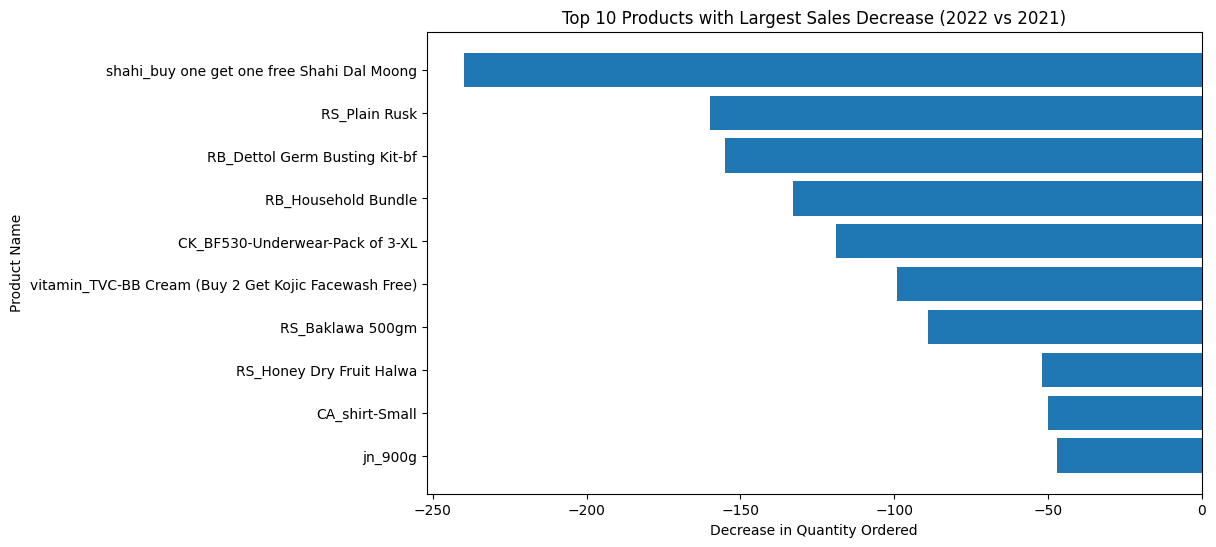

In [ ]:

sales_2021 = df[df['order_date'].dt.year == 2021].groupby('sku_name', as_index=False)['qty_ordered'].sum()
sales_2022 = df[df['order_date'].dt.year == 2022].groupby('sku_name', as_index=False)['qty_ordered'].sum()

sales_2021.rename(columns={'qty_ordered': 'qty_2021'}, inplace=True)
sales_2022.rename(columns={'qty_ordered': 'qty_2022'}, inplace=True)

merged = pd.merge(sales_2021, sales_2022, on='sku_name', how='outer').fillna(0)
merged['difference'] = merged['qty_2022'] - merged['qty_2021']

top10_decrease = merged.sort_values(by='difference', ascending=True).head(10)

plt.figure(figsize=(10,6))
plt.barh(top10_decrease['sku_name'], top10_decrease['difference'])
plt.xlabel('Decrease in Quantity Ordered')
plt.ylabel('Product Name')
plt.title('Top 10 Products with Largest Sales Decrease (2022 vs 2021)')
plt.gca().invert_yaxis()
plt.show()

top10_decrease.to_csv("Top10_Products_Decrease_2022vs2021.csv", index=False)


Task 6:Comparing Sales Trends for Multiple Categories in 2022 Scenario: The Marketing Team wants to compare the sales trends for multiple categories in 2022 to identify which category performed best. Requirements: 1. Aggregate the sales data by category for 2022. 2. Plot a time series of sales trends for each category (use order_date to group by month or week). 3. Provide insights on which category had the highest sales growth. Key Features to Use: • category • order_date (for time series analysis) • qty_ordered

<Figure size 1200x600 with 0 Axes>

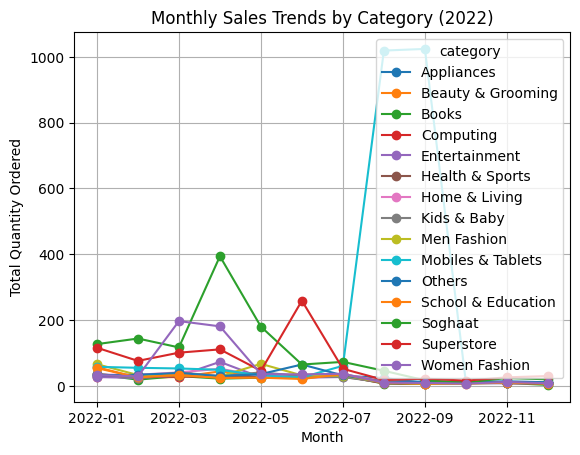

,category,qty_ordered
9,Mobiles & Tablets,2408


Category with the highest total sales in 2022: Mobiles & Tablets


In [ ]:

df_2022 = df[df['order_date'].dt.year == 2022]

df_2022['month'] = df_2022['order_date'].dt.to_period('M').astype(str)
category_trends = df_2022.groupby(['category', 'month'], as_index=False)['qty_ordered'].sum()

pivot_trends = category_trends.pivot(index='month', columns='category', values='qty_ordered').fillna(0)

plt.figure(figsize=(12,6))
pivot_trends.plot(marker='o')
plt.title('Monthly Sales Trends by Category (2022)')
plt.xlabel('Month')
plt.ylabel('Total Quantity Ordered')
plt.grid(True)
plt.show()

total_sales_2022 = df_2022.groupby('category', as_index=False)['qty_ordered'].sum().sort_values(by='qty_ordered', ascending=False)
category_trends.to_csv("Category_Trends_2022.csv", index=False)
total_sales_2022.to_csv("Category_Total_Sales_2022.csv", index=False)

display(total_sales_2022.head(1))
print("Category with the highest total sales in 2022:", total_sales_2022.iloc[0]['category'])
